In [2]:
"""
CELL: Load Test Data
Purpose: Load preprocessed test images for model evaluation
"""

import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import cv2

def load_test_data():
    """
    Load test data from data/test directory
    """
    
    test_dir = Path('data/processed/test')
    
    if not test_dir.exists():
        print(f"⚠ Test directory not found: {test_dir}")
        return None, None, None
    
    print("="*70)
    print("LOADING TEST DATA")
    print("="*70 + "\n")
    
    # Check for subdirectories (normal/abnormal) or direct images
    normal_dir = test_dir / 'normal'
    abnormal_dir = test_dir / 'abnormal'
    
    X_test = []
    y_test = []
    image_paths = []
    
    # If subdirectories exist (labeled data)
    if normal_dir.exists() or abnormal_dir.exists():
        print("📁 Found labeled test data (normal/abnormal folders)")
        
        # Load normal images
        if normal_dir.exists():
            normal_images = sorted(list(normal_dir.glob('*.png')) + 
                                 list(normal_dir.glob('*.jpg')) + 
                                 list(normal_dir.glob('*.jpeg')))
            print(f"\nLoading {len(normal_images)} normal images...")
            
            for img_path in tqdm(normal_images):
                try:
                    # Load image
                    img = load_img(img_path, target_size=(224, 224))
                    img_array = img_to_array(img) / 255.0
                    
                    X_test.append(img_array)
                    y_test.append(0)  # Normal = 0
                    image_paths.append(str(img_path))
                except Exception as e:
                    print(f"✗ Failed to load {img_path}: {e}")
        
        # Load abnormal images
        if abnormal_dir.exists():
            abnormal_images = sorted(list(abnormal_dir.glob('*.png')) + 
                                   list(abnormal_dir.glob('*.jpg')) + 
                                   list(abnormal_dir.glob('*.jpeg')))
            print(f"\nLoading {len(abnormal_images)} abnormal images...")
            
            for img_path in tqdm(abnormal_images):
                try:
                    # Load image
                    img = load_img(img_path, target_size=(224, 224))
                    img_array = img_to_array(img) / 255.0
                    
                    X_test.append(img_array)
                    y_test.append(1)  # Abnormal = 1
                    image_paths.append(str(img_path))
                except Exception as e:
                    print(f"✗ Failed to load {img_path}: {e}")
    
    else:
        # Load all images without labels
        print("📁 Found unlabeled test data (single folder)")
        
        all_images = sorted(list(test_dir.glob('*.png')) + 
                          list(test_dir.glob('*.jpg')) + 
                          list(test_dir.glob('*.jpeg')))
        
        print(f"\nLoading {len(all_images)} test images...")
        
        for img_path in tqdm(all_images):
            try:
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img) / 255.0
                
                X_test.append(img_array)
                y_test.append(-1)  # Unknown label
                image_paths.append(str(img_path))
            except Exception as e:
                print(f"✗ Failed to load {img_path}: {e}")
    
    if not X_test:
        print("\n⚠ No test images loaded!")
        return None, None, None
    
    # Convert to numpy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test) if -1 not in y_test else None
    
    print("\n" + "="*70)
    print(f"✅ Test data loaded successfully!")
    print(f"   Total images: {len(X_test)}")
    print(f"   Image shape: {X_test.shape}")
    
    if y_test is not None:
        print(f"   Normal: {np.sum(y_test == 0)}")
        print(f"   Abnormal: {np.sum(y_test == 1)}")
        print(f"   Labels available: Yes")
    else:
        print(f"   Labels available: No (unlabeled data)")
    
    print("="*70)
    
    return X_test, y_test, image_paths

# Load test data
X_test, y_test, test_image_paths = load_test_data()

if X_test is not None:
    print(f"\n✅ Test data ready for prediction!")
    print(f"   Shape: {X_test.shape}")
    print(f"   Data type: {X_test.dtype}")
    print(f"   Value range: [{X_test.min():.3f}, {X_test.max():.3f}]")

LOADING TEST DATA

📁 Found labeled test data (normal/abnormal folders)

Loading 59 normal images...


  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:00<00:00, 68.37it/s]



Loading 33 abnormal images...


100%|██████████| 33/33 [00:00<00:00, 75.24it/s]


✅ Test data loaded successfully!
   Total images: 92
   Image shape: (92, 224, 224, 3)
   Normal: 59
   Abnormal: 33
   Labels available: Yes

✅ Test data ready for prediction!
   Shape: (92, 224, 224, 3)
   Data type: float32
   Value range: [0.004, 1.000]


In [4]:
"""
CELL: Generate Predictions from Deep Learning Models (FIXED)
Purpose: Load saved models and generate predictions on test data with proper input handling
"""

from tensorflow import keras
import tensorflow as tf

def generate_dl_predictions(X_test, y_test):
    """
    Generate predictions from all deep learning models
    Handles different input requirements (RGB vs Grayscale)
    """
    
    if X_test is None:
        print("⚠ No test data available")
        return {}
    
    models_dir = Path('results/models')
    dl_models = ['custom_cnn', 'vgg16', 'resnet50', 'inception_v3', 'xception']
    
    predictions_test = {}
    
    print("\n" + "="*70)
    print("GENERATING PREDICTIONS FROM DEEP LEARNING MODELS")
    print("="*70 + "\n")
    
    # Prepare grayscale version for custom_cnn
    X_test_gray = np.mean(X_test, axis=-1, keepdims=True)
    print(f"📋 Test data prepared:")
    print(f"   RGB shape: {X_test.shape}")
    print(f"   Grayscale shape: {X_test_gray.shape}")
    print()
    
    for model_name in dl_models:
        print(f"\n{'='*70}")
        print(f"Processing: {model_name.upper()}")
        print(f"{'='*70}")
        
        predictions_test[model_name] = {
            'y_pred_folds': [],
            'y_prob_folds': [],
            'model_files': []
        }
        
        # Determine which input to use
        if model_name == 'custom_cnn':
            X_input = X_test_gray
            print("ℹ️  Using GRAYSCALE input for Custom CNN")
        else:
            X_input = X_test
            print("ℹ️  Using RGB input")
        
        # Load models from all folds
        for fold in range(5):
            model_file = models_dir / f'{model_name}_fold{fold}_best.h5'
            
            if not model_file.exists():
                print(f"⚠ Fold {fold}: Model not found - {model_file.name}")
                continue
            
            try:
                # Load model
                print(f"📥 Fold {fold}: Loading model... ", end='', flush=True)
                model = keras.models.load_model(model_file, compile=False)
                print("✓")
                
                # Verify input shape compatibility
                expected_shape = model.input_shape
                actual_shape = X_input.shape
                
                if expected_shape[1:] != actual_shape[1:]:
                    print(f"⚠ Fold {fold}: Shape mismatch!")
                    print(f"   Expected: {expected_shape}, Got: {actual_shape}")
                    print(f"   Skipping this fold...")
                    del model
                    tf.keras.backend.clear_session()
                    continue
                
                # Generate predictions
                print(f"🔮 Fold {fold}: Generating predictions... ", end='', flush=True)
                y_prob = model.predict(X_input, verbose=0, batch_size=32)
                print("✓")
                
                # Convert probabilities to predictions
                if len(y_prob.shape) > 1 and y_prob.shape[1] == 2:
                    # Binary classification with 2 outputs
                    y_pred = (y_prob[:, 1] > 0.5).astype(int)
                    y_prob_positive = y_prob[:, 1]
                else:
                    # Single output
                    y_pred = (y_prob > 0.5).astype(int).flatten()
                    y_prob_positive = y_prob.flatten()
                
                # Store predictions
                predictions_test[model_name]['y_pred_folds'].append(y_pred)
                predictions_test[model_name]['y_prob_folds'].append(y_prob_positive)
                predictions_test[model_name]['model_files'].append(model_file.name)
                
                # Calculate accuracy if labels available
                if y_test is not None:
                    accuracy = np.mean(y_pred == y_test)
                    print(f"📊 Fold {fold}: Test Accuracy = {accuracy:.4f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"\n✗ Fold {fold}: Error - {str(e)[:100]}")
                # Try to clean up even on error
                try:
                    if 'model' in locals():
                        del model
                    tf.keras.backend.clear_session()
                except:
                    pass
                continue
        
        # Calculate ensemble predictions (average across folds)
        if predictions_test[model_name]['y_pred_folds']:
            n_folds = len(predictions_test[model_name]['y_pred_folds'])
            print(f"\n📊 {model_name.upper()} Summary:")
            print(f"   Models loaded: {n_folds}/5 folds")
            
            # Ensemble prediction (majority vote)
            all_preds = np.array(predictions_test[model_name]['y_pred_folds'])
            ensemble_pred = (np.mean(all_preds, axis=0) > 0.5).astype(int)
            
            # Ensemble probability (average)
            all_probs = np.array(predictions_test[model_name]['y_prob_folds'])
            ensemble_prob = np.mean(all_probs, axis=0)
            
            predictions_test[model_name]['y_pred_ensemble'] = ensemble_pred
            predictions_test[model_name]['y_prob_ensemble'] = ensemble_prob
            
            if y_test is not None:
                ensemble_acc = np.mean(ensemble_pred == y_test)
                print(f"   Ensemble Test Accuracy: {ensemble_acc:.4f}")
                
                # Per-fold accuracy
                fold_accs = [np.mean(pred == y_test) 
                           for pred in predictions_test[model_name]['y_pred_folds']]
                print(f"   Fold accuracies: {[f'{acc:.4f}' for acc in fold_accs]}")
                print(f"   Mean ± Std: {np.mean(fold_accs):.4f} ± {np.std(fold_accs):.4f}")
        else:
            print(f"\n⚠ {model_name.upper()}: No successful predictions")
    
    print("\n" + "="*70)
    print("PREDICTION GENERATION COMPLETE")
    print("="*70)
    
    # Summary
    successful_models = [m for m in dl_models 
                        if m in predictions_test 
                        and 'y_pred_ensemble' in predictions_test[m]]
    
    print(f"\n✅ Successfully generated predictions for {len(successful_models)}/{len(dl_models)} models:")
    for model in successful_models:
        print(f"   • {model.upper()}")
    
    if len(successful_models) < len(dl_models):
        failed_models = [m for m in dl_models if m not in successful_models]
        print(f"\n⚠ Failed models: {', '.join(failed_models)}")
    
    return predictions_test

# Generate predictions
test_predictions_dl = generate_dl_predictions(X_test, y_test)


GENERATING PREDICTIONS FROM DEEP LEARNING MODELS

📋 Test data prepared:
   RGB shape: (92, 224, 224, 3)
   Grayscale shape: (92, 224, 224, 1)


Processing: CUSTOM_CNN
ℹ️  Using GRAYSCALE input for Custom CNN
📥 Fold 0: Loading model... ✓
🔮 Fold 0: Generating predictions... ✓
📊 Fold 0: Test Accuracy = 0.6413
📥 Fold 1: Loading model... ✓
🔮 Fold 1: Generating predictions... ✓
📊 Fold 1: Test Accuracy = 0.7609
📥 Fold 2: Loading model... ✓
🔮 Fold 2: Generating predictions... ✓
📊 Fold 2: Test Accuracy = 0.6957
📥 Fold 3: Loading model... ✓
🔮 Fold 3: Generating predictions... ✓
📊 Fold 3: Test Accuracy = 0.7500
📥 Fold 4: Loading model... ✓
🔮 Fold 4: Generating predictions... ✓
📊 Fold 4: Test Accuracy = 0.3587

📊 CUSTOM_CNN Summary:
   Models loaded: 5/5 folds
   Ensemble Test Accuracy: 0.7500
   Fold accuracies: ['0.6413', '0.7609', '0.6957', '0.7500', '0.3587']
   Mean ± Std: 0.6413 ± 0.1476

Processing: VGG16
ℹ️  Using RGB input
📥 Fold 0: Loading model... ✓
🔮 Fold 0: Generating predictions... 

In [17]:
"""
CELL: Correct SVM Prediction - Use VGG16 Feature Extraction
Purpose: Extract features using VGG16 (same as training)
"""

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

def create_vgg16_feature_extractor():
    """
    Create VGG16 feature extractor (fc2 layer - 4096 dimensions)
    Same as used in training
    """
    
    print("Creating VGG16 feature extractor...")
    
    # Load VGG16
    base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    
    # Extract fc2 layer (4096 features)
    feature_extractor = Model(
        inputs=base_model.input,
        outputs=base_model.get_layer('fc2').output
    )
    
    print(f"✓ VGG16 feature extractor created")
    print(f"  Output shape: {feature_extractor.output_shape}")
    print(f"  Features: 4096 dimensions")
    
    return feature_extractor

def extract_vgg16_features(X_test, feature_extractor):
    """
    Extract VGG16 features from test images
    
    Args:
        X_test: Test images (N, 224, 224, 3) normalized [0,1]
        feature_extractor: VGG16 model
    
    Returns:
        features: (N, 4096) array
    """
    
    print(f"\n📊 Extracting VGG16 features from {len(X_test)} images...")
    
    # Convert grayscale to 3-channel if needed
    if X_test.shape[-1] == 1:
        print("Converting grayscale to 3-channel...")
        X_test_3ch = np.repeat(X_test, 3, axis=-1)
    else:
        X_test_3ch = X_test
    
    # Preprocess for VGG16 (same as training)
    # Input should be in [0, 255] range for preprocess_input
    X_test_vgg = preprocess_input(X_test_3ch * 255.0)
    
    print(f"After VGG16 preprocessing:")
    print(f"  Shape: {X_test_vgg.shape}")
    print(f"  Range: [{X_test_vgg.min():.3f}, {X_test_vgg.max():.3f}]")
    
    # Extract features
    print("Extracting features (this may take a moment)...")
    features = feature_extractor.predict(X_test_vgg, batch_size=32, verbose=1)
    
    print(f"✅ Features extracted: {features.shape}")
    print(f"   Range: [{features.min():.3f}, {features.max():.3f}]")
    print(f"   Mean: {features.mean():.3f}")
    print(f"   Std: {features.std():.3f}")
    
    return features

def generate_svm_predictions_vgg16(X_test, y_test):
    """
    Generate SVM predictions using VGG16 features (CORRECT METHOD)
    """
    
    if X_test is None:
        print("⚠ No test data available")
        return {}
    
    print("\n" + "="*70)
    print("GENERATING SVM PREDICTIONS (VGG16 FEATURES)")
    print("="*70)
    print("Using same feature extraction as training:")
    print("  VGG16 fc2 layer → 4096 dimensions → StandardScaler → SVM")
    print("="*70 + "\n")
    
    # Create VGG16 feature extractor
    feature_extractor = create_vgg16_feature_extractor()
    
    # Extract features
    features_test = extract_vgg16_features(X_test, feature_extractor)
    
    svm_base_dir = Path('results/svm_features')
    
    predictions_test = {
        'y_pred_folds': [],
        'y_prob_folds': [],
        'model_files': []
    }
    
    for fold in range(5):
        fold_dir = svm_base_dir / f'fold{fold}'
        
        if not fold_dir.exists():
            continue
        
        print(f"\n{'='*50}")
        print(f"Fold {fold}")
        print(f"{'='*50}")
        
        # Load scaler
        scaler_path = fold_dir / 'scaler.pkl'
        if not scaler_path.exists():
            print(f"⚠ Scaler not found")
            continue
        
        scaler = joblib.load(scaler_path)
        print(f"✓ Scaler loaded")
        
        # Verify feature dimensions
        if features_test.shape[1] != scaler.n_features_in_:
            print(f"⚠️  Feature dimension mismatch!")
            print(f"   Extracted: {features_test.shape[1]}")
            print(f"   Expected: {scaler.n_features_in_}")
            continue
        
        # Scale features
        features_scaled = scaler.transform(features_test)
        
        print(f"After scaling:")
        print(f"  Range: [{features_scaled.min():.3f}, {features_scaled.max():.3f}]")
        print(f"  Mean: {features_scaled.mean():.3f}")
        print(f"  Std: {features_scaled.std():.3f}")
        
        # Load SVM classifier
        svm_path = fold_dir / 'svm_classifier.pkl'
        if not svm_path.exists():
            print(f"⚠ SVM classifier not found")
            continue
        
        svm_model = joblib.load(svm_path)
        print(f"✓ SVM classifier loaded: {svm_model.__class__.__name__}")
        
        # Predict
        y_pred = svm_model.predict(features_scaled)
        
        # Get probabilities
        if hasattr(svm_model, 'predict_proba'):
            y_prob = svm_model.predict_proba(features_scaled)[:, 1]
            print(f"✓ Probabilities from predict_proba")
        elif hasattr(svm_model, 'decision_function'):
            decision = svm_model.decision_function(features_scaled)
            y_prob = 1 / (1 + np.exp(-decision))
            print(f"✓ Probabilities from decision_function")
        else:
            y_prob = y_pred.astype(float)
        
        # Check decision function
        if hasattr(svm_model, 'decision_function'):
            decision = svm_model.decision_function(features_scaled)
            print(f"\nDecision function:")
            print(f"  Range: [{decision.min():.3f}, {decision.max():.3f}]")
            print(f"  Mean: {decision.mean():.3f}")
            print(f"  Positive predictions (decision > 0): {np.sum(decision > 0)}/{len(decision)}")
        
        # Store predictions
        predictions_test['y_pred_folds'].append(y_pred)
        predictions_test['y_prob_folds'].append(y_prob)
        predictions_test['model_files'].append(f'fold{fold}')
        
        # Prediction distribution
        unique, counts = np.unique(y_pred, return_counts=True)
        print(f"\nPredictions:")
        for u, c in zip(unique, counts):
            name = 'Normal' if u == 0 else 'Abnormal'
            print(f"  {name} (class {u}): {c:3d} ({c/len(y_pred)*100:5.1f}%)")
        
        # Accuracy if labels available
        if y_test is not None:
            accuracy = np.mean(y_pred == y_test)
            
            # Per-class accuracy
            mask_normal = y_test == 0
            mask_abnormal = y_test == 1
            
            if mask_normal.sum() > 0:
                acc_normal = np.mean(y_pred[mask_normal] == y_test[mask_normal])
                print(f"\nAccuracy on Normal: {acc_normal:.4f} ({mask_normal.sum()} samples)")
            
            if mask_abnormal.sum() > 0:
                acc_abnormal = np.mean(y_pred[mask_abnormal] == y_test[mask_abnormal])
                print(f"Accuracy on Abnormal: {acc_abnormal:.4f} ({mask_abnormal.sum()} samples)")
            
            print(f"\n📊 Overall Accuracy: {accuracy:.4f}")
    
    # Ensemble predictions
    if predictions_test['y_pred_folds']:
        n_folds = len(predictions_test['y_pred_folds'])
        
        print(f"\n{'='*70}")
        print(f"SVM ENSEMBLE RESULTS")
        print(f"{'='*70}")
        print(f"Folds used: {n_folds}/5\n")
        
        # Ensemble (majority vote)
        all_preds = np.array(predictions_test['y_pred_folds'])
        ensemble_pred = (np.mean(all_preds, axis=0) > 0.5).astype(int)
        
        # Ensemble probability
        all_probs = np.array(predictions_test['y_prob_folds'])
        ensemble_prob = np.mean(all_probs, axis=0)
        
        predictions_test['y_pred_ensemble'] = ensemble_pred
        predictions_test['y_prob_ensemble'] = ensemble_prob
        
        # Distribution
        unique, counts = np.unique(ensemble_pred, return_counts=True)
        print(f"Ensemble Predictions:")
        for u, c in zip(unique, counts):
            name = 'Normal' if u == 0 else 'Abnormal'
            print(f"  {name} (class {u}): {c:3d} ({c/len(ensemble_pred)*100:5.1f}%)")
        
        if y_test is not None:
            ensemble_acc = np.mean(ensemble_pred == y_test)
            
            # Per-class
            mask_normal = y_test == 0
            mask_abnormal = y_test == 1
            
            print(f"\nEnsemble Performance:")
            if mask_normal.sum() > 0:
                acc_normal = np.mean(ensemble_pred[mask_normal] == y_test[mask_normal])
                print(f"  Accuracy on Normal: {acc_normal:.4f}")
            
            if mask_abnormal.sum() > 0:
                acc_abnormal = np.mean(ensemble_pred[mask_abnormal] == y_test[mask_abnormal])
                print(f"  Accuracy on Abnormal: {acc_abnormal:.4f}")
            
            print(f"\n✅ Overall Ensemble Accuracy: {ensemble_acc:.4f}")
            
            # Confusion matrix
            cm = confusion_matrix(y_test, ensemble_pred)
            print(f"\nConfusion Matrix:")
            print(f"              Predicted")
            print(f"            Normal  Abnormal")
            print(f"True Normal   {cm[0,0]:3d}      {cm[0,1]:3d}")
            print(f"     Abnormal {cm[1,0]:3d}      {cm[1,1]:3d}")
        
        print(f"{'='*70}\n")
    else:
        print("\n⚠️  No successful SVM predictions generated")
    
    # Clean up
    del feature_extractor
    tf.keras.backend.clear_session()
    
    return predictions_test

# Generate SVM predictions with correct method
print("\n🔧 GENERATING SVM PREDICTIONS WITH CORRECT FEATURE EXTRACTION")
print("="*70)
print("Method: VGG16 fc2 layer features (4096-dim) → StandardScaler → SVM")
print("This matches the training process exactly")
print("="*70 + "\n")

test_predictions_svm_correct = generate_svm_predictions_vgg16(X_test, y_test)

# Update all predictions
if 'y_pred_ensemble' in test_predictions_svm_correct:
    all_test_predictions['svm'] = test_predictions_svm_correct
    print("\n✅ SVM predictions updated successfully!")
    print("   Now all models use correct feature extraction")
else:
    print("\n⚠️  SVM prediction failed")


🔧 GENERATING SVM PREDICTIONS WITH CORRECT FEATURE EXTRACTION
Method: VGG16 fc2 layer features (4096-dim) → StandardScaler → SVM
This matches the training process exactly


GENERATING SVM PREDICTIONS (VGG16 FEATURES)
Using same feature extraction as training:
  VGG16 fc2 layer → 4096 dimensions → StandardScaler → SVM

Creating VGG16 feature extractor...
✓ VGG16 feature extractor created
  Output shape: (None, 4096)
  Features: 4096 dimensions

📊 Extracting VGG16 features from 92 images...
After VGG16 preprocessing:
  Shape: (92, 224, 224, 3)
  Range: [-122.680, 151.061]
Extracting features (this may take a moment)...
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step
✅ Features extracted: (92, 4096)
   Range: [0.000, 11.311]
   Mean: 0.381
   Std: 0.901

Fold 0
✓ Scaler loaded
After scaling:
  Range: [-3.109, 18949.430]
  Mean: 0.038
  Std: 30.909
✓ SVM classifier loaded: SVC
✓ Probabilities from predict_proba

Decision function:
  Range: [-1.402, 0.790]
  Mean: -0.413
  Positive predictions (decisi

In [19]:
"""
CELL: Combine All Test Predictions
Purpose: Organize all predictions for visualization
"""

# Combine all predictions
all_test_predictions = {}

# Add SVM if available
if 'test_predictions_svm_correct' in locals() and test_predictions_svm_correct:
    all_test_predictions['svm'] = test_predictions_svm_correct
elif 'test_predictions_svm' in locals() and test_predictions_svm:
    all_test_predictions['svm'] = test_predictions_svm

# Add Deep Learning models
if 'test_predictions_dl' in locals() and test_predictions_dl:
    all_test_predictions.update(test_predictions_dl)

# Summary
print("\n" + "="*80)
print("TEST PREDICTIONS SUMMARY")
print("="*80)

available_models = []

for model_name, preds in all_test_predictions.items():
    if 'y_pred_ensemble' in preds:
        n_folds = len(preds['y_pred_folds'])
        print(f"\n{model_name.upper()}:")
        print(f"  ✓ Predictions from {n_folds}/5 folds")
        print(f"  ✓ Ensemble prediction available")
        
        available_models.append(model_name)
        
        if y_test is not None:
            acc = np.mean(preds['y_pred_ensemble'] == y_test)
            
            # Check prediction distribution
            unique, counts = np.unique(preds['y_pred_ensemble'], return_counts=True)
            print(f"  📊 Prediction distribution:")
            for u, c in zip(unique, counts):
                class_name = 'Normal' if u == 0 else 'Abnormal'
                print(f"     {class_name}: {c} samples ({c/len(preds['y_pred_ensemble'])*100:.1f}%)")
            
            print(f"  📊 Ensemble Test Accuracy: {acc:.4f}")
    else:
        print(f"\n{model_name.upper()}:")
        print(f"  ⚠ No ensemble predictions available")

print(f"\n{'='*80}")
print(f"✅ Total models with predictions: {len(available_models)}")
print(f"   Models: {', '.join([m.upper() for m in available_models])}")
print(f"{'='*80}\n")


TEST PREDICTIONS SUMMARY

SVM:
  ✓ Predictions from 5/5 folds
  ✓ Ensemble prediction available
  📊 Prediction distribution:
     Normal: 77 samples (83.7%)
     Abnormal: 15 samples (16.3%)
  📊 Ensemble Test Accuracy: 0.7826

CUSTOM_CNN:
  ✓ Predictions from 5/5 folds
  ✓ Ensemble prediction available
  📊 Prediction distribution:
     Normal: 68 samples (73.9%)
     Abnormal: 24 samples (26.1%)
  📊 Ensemble Test Accuracy: 0.7500

VGG16:
  ✓ Predictions from 5/5 folds
  ✓ Ensemble prediction available
  📊 Prediction distribution:
     Normal: 68 samples (73.9%)
     Abnormal: 24 samples (26.1%)
  📊 Ensemble Test Accuracy: 0.7935

RESNET50:
  ✓ Predictions from 5/5 folds
  ✓ Ensemble prediction available
  📊 Prediction distribution:
     Normal: 77 samples (83.7%)
     Abnormal: 15 samples (16.3%)
  📊 Ensemble Test Accuracy: 0.7609

INCEPTION_V3:
  ✓ Predictions from 5/5 folds
  ✓ Ensemble prediction available
  📊 Prediction distribution:
     Normal: 67 samples (72.8%)
     Abnormal: 

In [20]:
"""
CELL: Setup Directories for Visualization
Purpose: Create necessary directories for saving results
"""

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Create directories
figures_extended_dir = Path('results/figures/extended_analysis')
figures_extended_dir.mkdir(parents=True, exist_ok=True)

test_pred_dir = Path('results/test_predictions')
test_pred_dir.mkdir(parents=True, exist_ok=True)

# Set style
plt.style.use('default')
sns.set_palette("husl")

print(f"✅ Directories created:")
print(f"   Figures: {figures_extended_dir}")
print(f"   Predictions: {test_pred_dir}")

✅ Directories created:
   Figures: results\figures\extended_analysis
   Predictions: results\test_predictions



GENERATING INDIVIDUAL CONFUSION MATRICES


📊 Processing SVM...
✅ Saved: svm_confusion_matrix_test.png


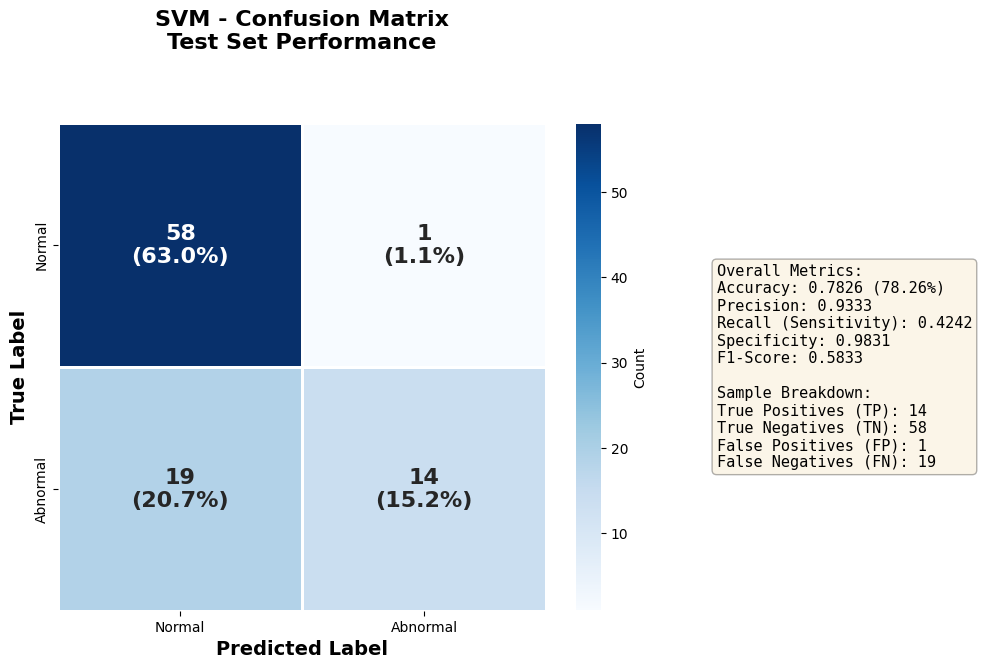

   Metrics:
     Accuracy:    0.7826
     Precision:   0.9333
     Recall:      0.4242
     Specificity: 0.9831
     F1-Score:    0.5833
   Confusion Matrix:
     TP:  14  |  FP:   1
     FN:  19  |  TN:  58

📊 Processing CUSTOM_CNN...
✅ Saved: custom_cnn_confusion_matrix_test.png


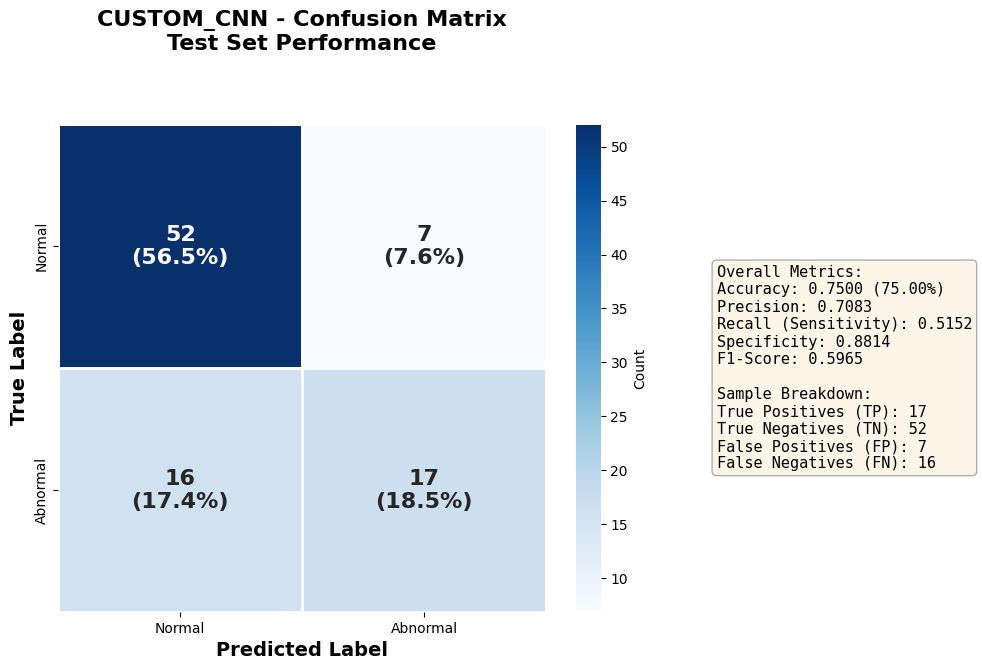

   Metrics:
     Accuracy:    0.7500
     Precision:   0.7083
     Recall:      0.5152
     Specificity: 0.8814
     F1-Score:    0.5965
   Confusion Matrix:
     TP:  17  |  FP:   7
     FN:  16  |  TN:  52

📊 Processing VGG16...
✅ Saved: vgg16_confusion_matrix_test.png


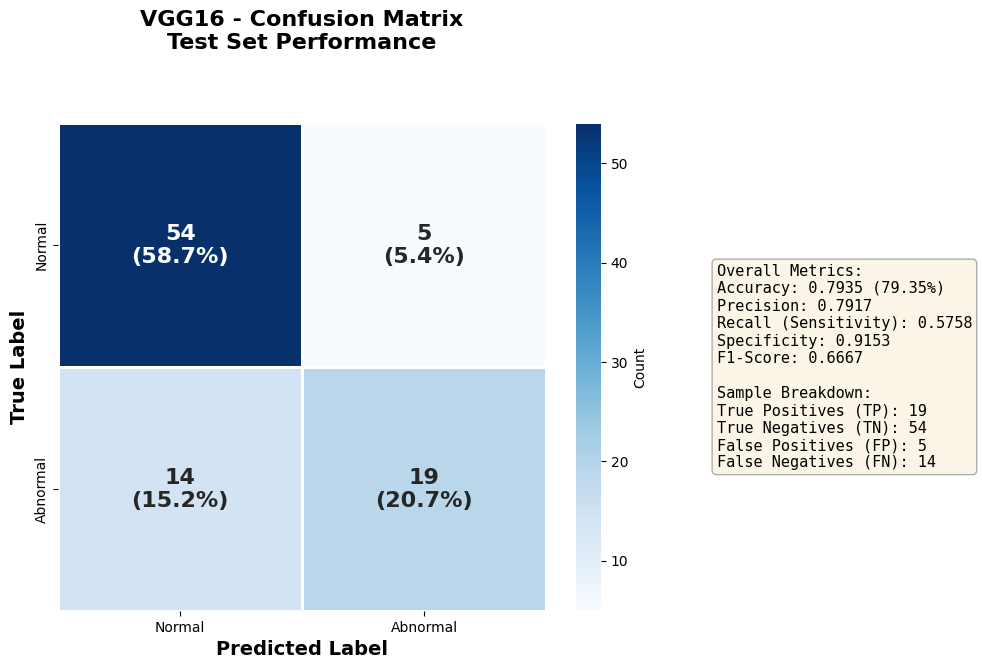

   Metrics:
     Accuracy:    0.7935
     Precision:   0.7917
     Recall:      0.5758
     Specificity: 0.9153
     F1-Score:    0.6667
   Confusion Matrix:
     TP:  19  |  FP:   5
     FN:  14  |  TN:  54

📊 Processing RESNET50...
✅ Saved: resnet50_confusion_matrix_test.png


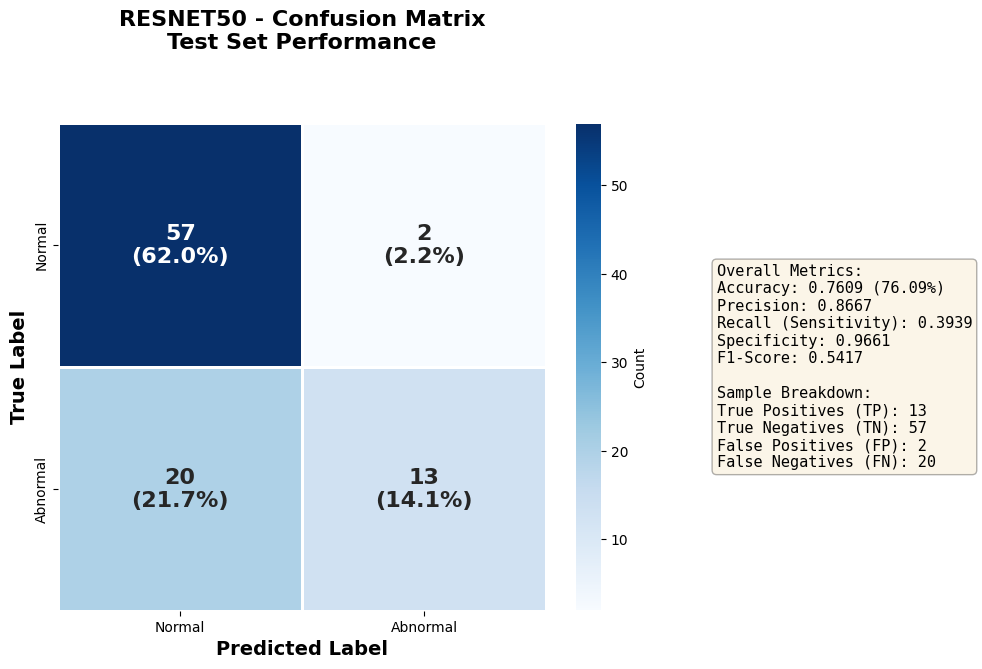

   Metrics:
     Accuracy:    0.7609
     Precision:   0.8667
     Recall:      0.3939
     Specificity: 0.9661
     F1-Score:    0.5417
   Confusion Matrix:
     TP:  13  |  FP:   2
     FN:  20  |  TN:  57

📊 Processing INCEPTION_V3...
✅ Saved: inception_v3_confusion_matrix_test.png


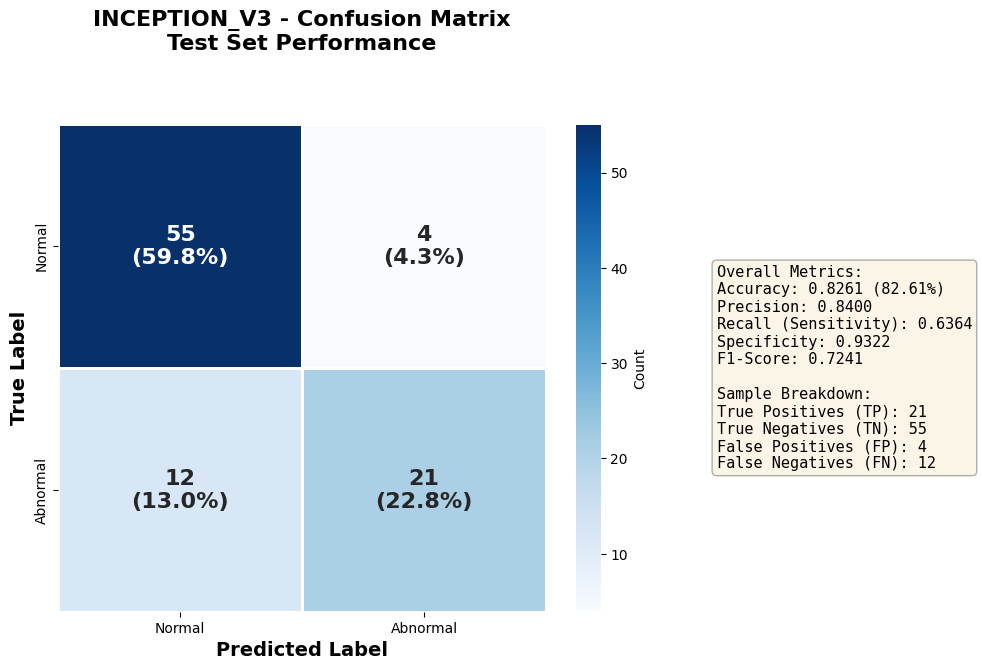

   Metrics:
     Accuracy:    0.8261
     Precision:   0.8400
     Recall:      0.6364
     Specificity: 0.9322
     F1-Score:    0.7241
   Confusion Matrix:
     TP:  21  |  FP:   4
     FN:  12  |  TN:  55

📊 Processing XCEPTION...
✅ Saved: xception_confusion_matrix_test.png


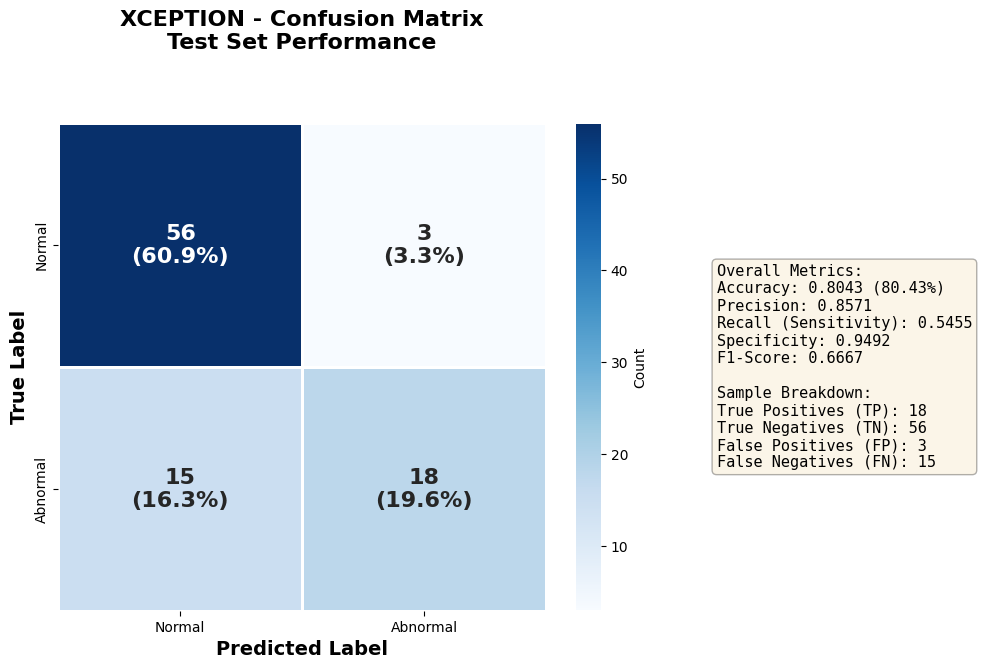

   Metrics:
     Accuracy:    0.8043
     Precision:   0.8571
     Recall:      0.5455
     Specificity: 0.9492
     F1-Score:    0.6667
   Confusion Matrix:
     TP:  18  |  FP:   3
     FN:  15  |  TN:  56

✅ All individual confusion matrices generated!
   Saved to: results\figures\extended_analysis


In [22]:
"""
CELL: Individual Confusion Matrices (Separate Figures)
Purpose: Create one high-quality confusion matrix per model
"""

def plot_individual_confusion_matrix(model_name, y_true, y_pred, save_dir):
    """
    Create a single confusion matrix figure for one model
    
    Args:
        model_name: Name of the model
        y_true: True labels
        y_pred: Predicted labels
        save_dir: Directory to save figure
    
    Returns:
        Dictionary with calculated metrics
    """
    
    # Create figure with better size
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate all metrics
    accuracy = np.mean(y_pred == y_true)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate percentages for each cell
    cm_sum = np.sum(cm)
    cm_perc = (cm / cm_sum) * 100
    
    # Create annotations with count and percentage
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_perc[i, j]:.1f}%)'
    
    # Plot heatmap
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
               cbar=True, square=True, ax=ax,
               xticklabels=['Normal', 'Abnormal'],
               yticklabels=['Normal', 'Abnormal'],
               annot_kws={'size': 16, 'weight': 'bold'},
               linewidths=2, linecolor='white',
               cbar_kws={'label': 'Count', 'shrink': 0.8})
    
    # Title with comprehensive metrics
    title_text = (
        f'{model_name.upper()} - Confusion Matrix\n'
        f'Test Set Performance\n\n'
    )
    
    ax.set_title(title_text, fontsize=16, fontweight='bold', pad=20)
    
    # Add metrics text box
    metrics_text = (
        f'Overall Metrics:\n'
        f'Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n'
        f'Precision: {precision:.4f}\n'
        f'Recall (Sensitivity): {recall:.4f}\n'
        f'Specificity: {specificity:.4f}\n'
        f'F1-Score: {f1:.4f}\n\n'
        f'Sample Breakdown:\n'
        f'True Positives (TP): {tp}\n'
        f'True Negatives (TN): {tn}\n'
        f'False Positives (FP): {fp}\n'
        f'False Negatives (FN): {fn}'
    )
    
    # Add text box with metrics
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    ax.text(1.35, 0.5, metrics_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='center',
            bbox=props, family='monospace')
    
    # Labels
    ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    
    # Adjust layout to make room for text box
    plt.tight_layout()
    
    # Save
    save_path = save_dir / f'{model_name}_confusion_matrix_test.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {save_path.name}")
    
    plt.show()
    plt.close()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'cm': cm,
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn)
    }


# Generate individual confusion matrices
print("\n" + "="*70)
print("GENERATING INDIVIDUAL CONFUSION MATRICES")
print("="*70 + "\n")

all_models = ['svm', 'custom_cnn', 'vgg16', 'resnet50', 'inception_v3', 'xception']
test_metrics_summary = {}

for model_name in all_models:
    if model_name in all_test_predictions and 'y_pred_ensemble' in all_test_predictions[model_name]:
        print(f"\n📊 Processing {model_name.upper()}...")
        
        y_pred = all_test_predictions[model_name]['y_pred_ensemble']
        
        # Check if predictions are valid (not all same class)
        unique_preds = np.unique(y_pred)
        if len(unique_preds) == 1:
            print(f"   ⚠️  WARNING: All predictions are class {unique_preds[0]}")
            print(f"   This model may have feature extraction issues")
        
        metrics = plot_individual_confusion_matrix(
            model_name, y_test, y_pred, figures_extended_dir
        )
        
        test_metrics_summary[model_name] = metrics
        
        # Print summary
        print(f"   Metrics:")
        print(f"     Accuracy:    {metrics['accuracy']:.4f}")
        print(f"     Precision:   {metrics['precision']:.4f}")
        print(f"     Recall:      {metrics['recall']:.4f}")
        print(f"     Specificity: {metrics['specificity']:.4f}")
        print(f"     F1-Score:    {metrics['f1']:.4f}")
        print(f"   Confusion Matrix:")
        print(f"     TP: {metrics['tp']:3d}  |  FP: {metrics['fp']:3d}")
        print(f"     FN: {metrics['fn']:3d}  |  TN: {metrics['tn']:3d}")
    else:
        print(f"⚠ {model_name.upper()}: No predictions available")

print("\n" + "="*70)
print("✅ All individual confusion matrices generated!")
print(f"   Saved to: {figures_extended_dir}")
print("="*70)

In [23]:
"""
CELL: Save Test Predictions
Purpose: Save all predictions for future analysis
"""

print("\n" + "="*70)
print("SAVING TEST PREDICTIONS")
print("="*70 + "\n")

for model_name, preds in all_test_predictions.items():
    if 'y_pred_ensemble' in preds:
        # Save ensemble predictions
        np.save(test_pred_dir / f'{model_name}_test_pred_ensemble.npy', 
                preds['y_pred_ensemble'])
        np.save(test_pred_dir / f'{model_name}_test_prob_ensemble.npy', 
                preds['y_prob_ensemble'])
        
        # Save individual fold predictions
        for i, (pred, prob) in enumerate(zip(preds['y_pred_folds'], 
                                             preds['y_prob_folds'])):
            np.save(test_pred_dir / f'{model_name}_test_pred_fold{i}.npy', pred)
            np.save(test_pred_dir / f'{model_name}_test_prob_fold{i}.npy', prob)
        
        print(f"✅ Saved {model_name} predictions ({len(preds['y_pred_folds'])} folds)")

# Save test labels
if y_test is not None:
    np.save(test_pred_dir / 'y_test.npy', y_test)
    print(f"✅ Saved test labels")

print(f"\n📁 All predictions saved to: {test_pred_dir}")
print("="*70 + "\n")


SAVING TEST PREDICTIONS

✅ Saved svm predictions (5 folds)
✅ Saved custom_cnn predictions (5 folds)
✅ Saved vgg16 predictions (5 folds)
✅ Saved resnet50 predictions (5 folds)
✅ Saved inception_v3 predictions (5 folds)
✅ Saved xception predictions (5 folds)
✅ Saved test labels

📁 All predictions saved to: results\test_predictions




GENERATING INDIVIDUAL ROC CURVES


📈 Processing SVM...
✅ Saved: svm_roc_curve_test.png


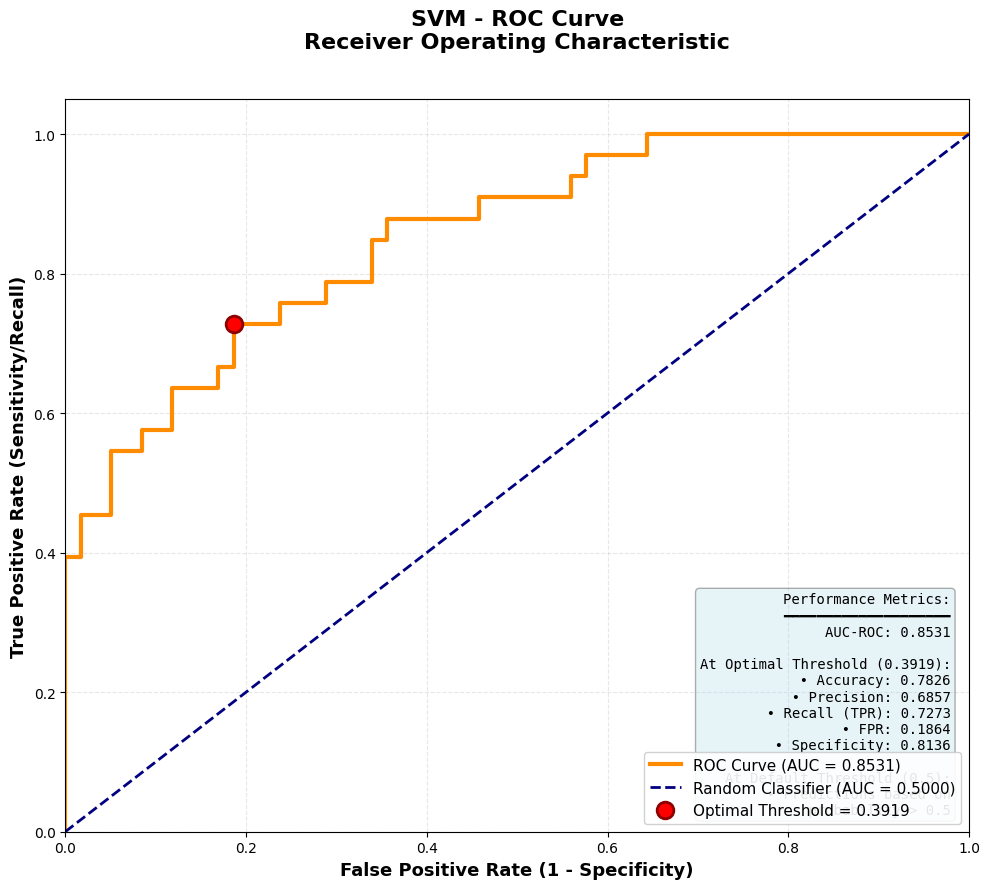

   AUC-ROC: 0.8531
   Optimal Threshold: 0.3919
   At optimal threshold:
     Accuracy: 0.7826
     TPR: 0.7273
     FPR: 0.1864

📈 Processing CUSTOM_CNN...
✅ Saved: custom_cnn_roc_curve_test.png


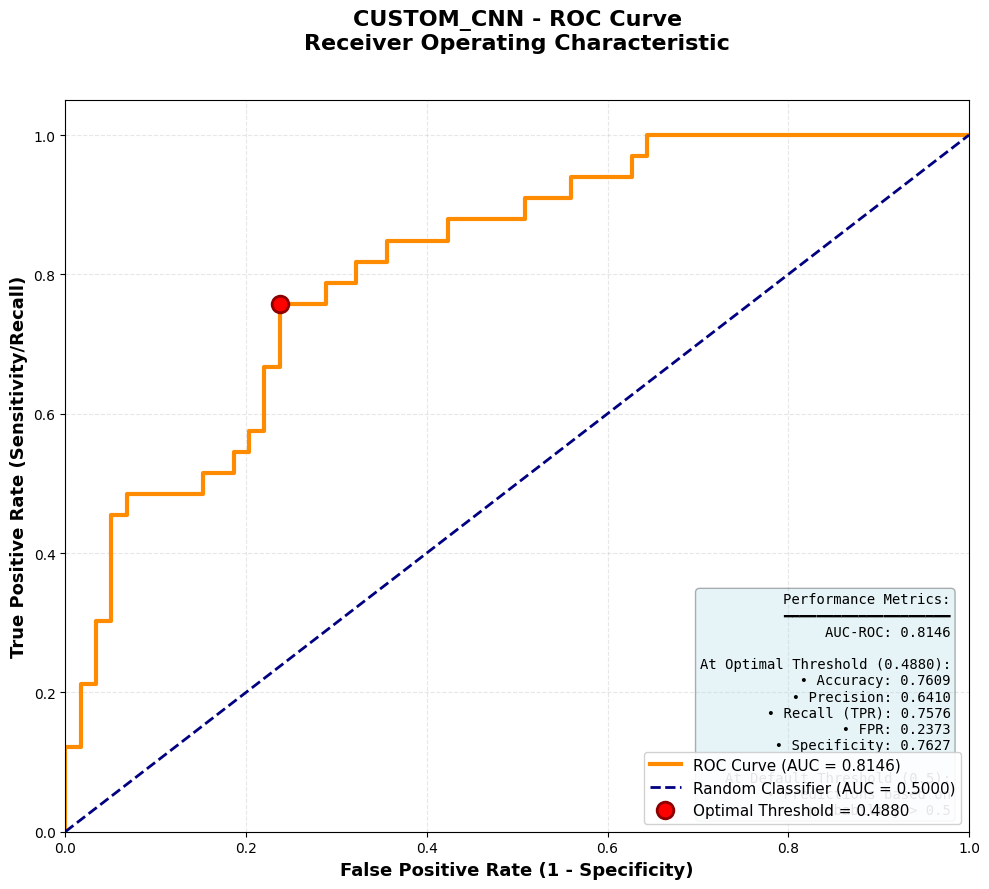

   AUC-ROC: 0.8146
   Optimal Threshold: 0.4880
   At optimal threshold:
     Accuracy: 0.7609
     TPR: 0.7576
     FPR: 0.2373

📈 Processing VGG16...
✅ Saved: vgg16_roc_curve_test.png


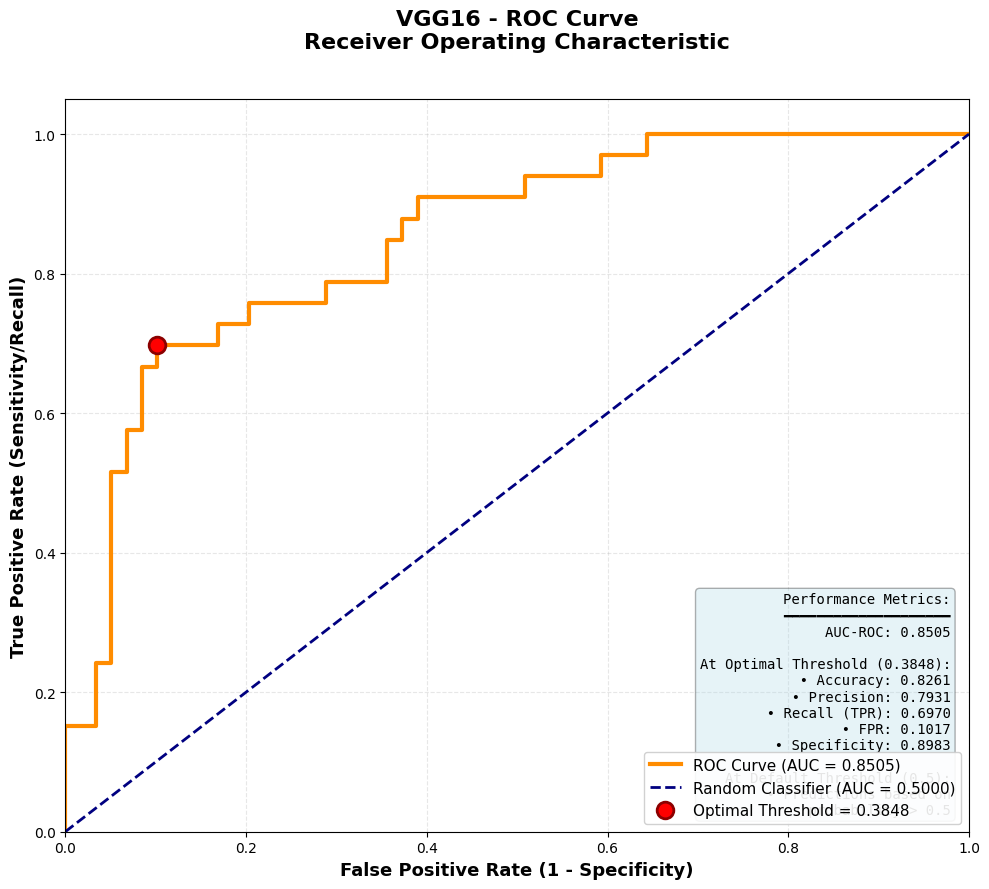

   AUC-ROC: 0.8505
   Optimal Threshold: 0.3848
   At optimal threshold:
     Accuracy: 0.8261
     TPR: 0.6970
     FPR: 0.1017

📈 Processing RESNET50...
✅ Saved: resnet50_roc_curve_test.png


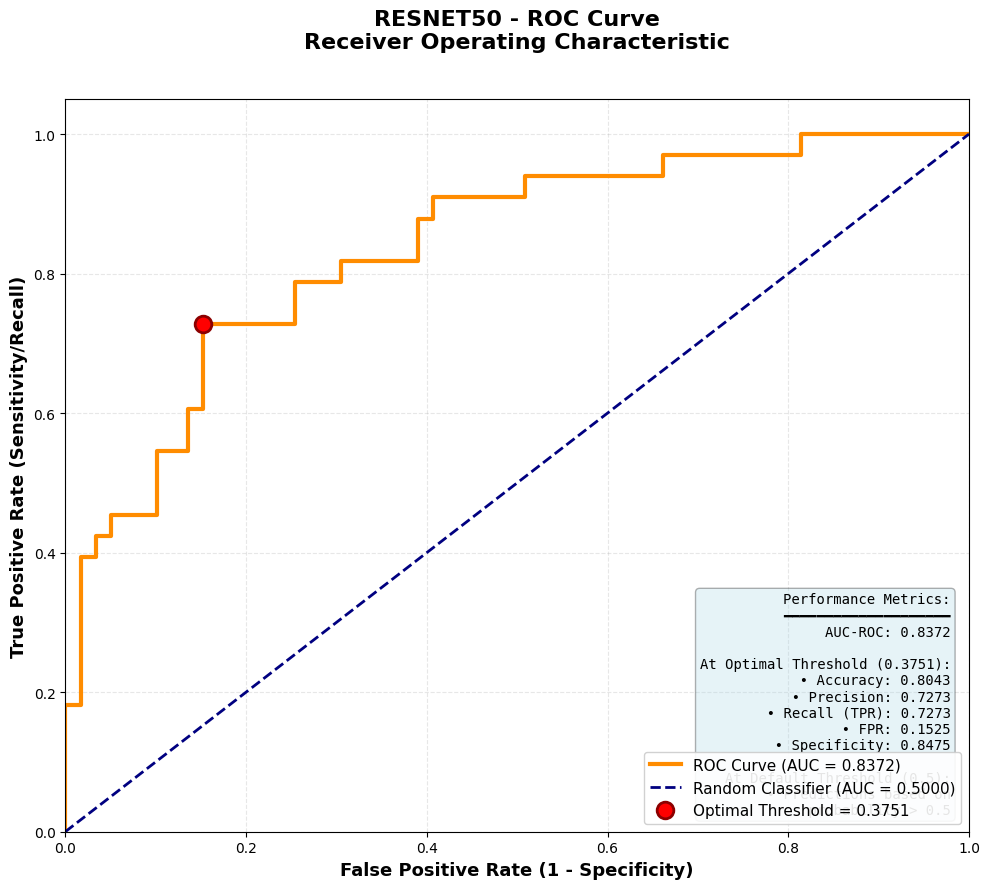

   AUC-ROC: 0.8372
   Optimal Threshold: 0.3751
   At optimal threshold:
     Accuracy: 0.8043
     TPR: 0.7273
     FPR: 0.1525

📈 Processing INCEPTION_V3...
✅ Saved: inception_v3_roc_curve_test.png


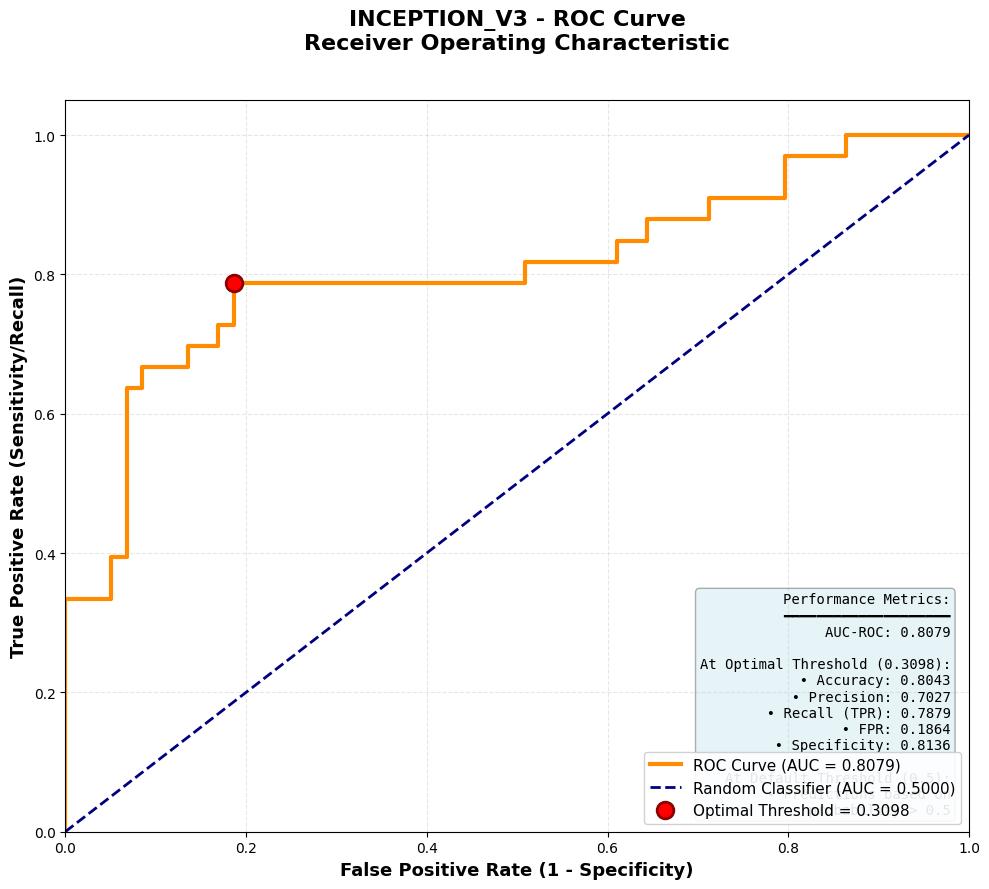

   AUC-ROC: 0.8079
   Optimal Threshold: 0.3098
   At optimal threshold:
     Accuracy: 0.8043
     TPR: 0.7879
     FPR: 0.1864

📈 Processing XCEPTION...
✅ Saved: xception_roc_curve_test.png


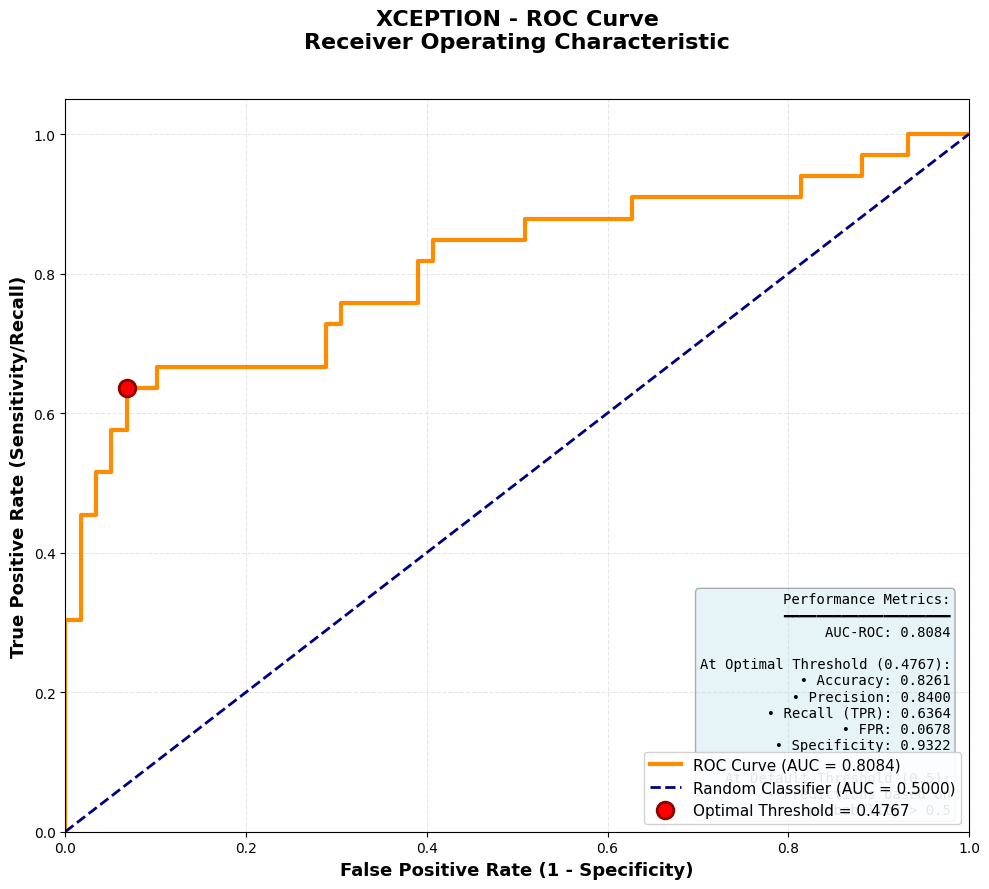

   AUC-ROC: 0.8084
   Optimal Threshold: 0.4767
   At optimal threshold:
     Accuracy: 0.8261
     TPR: 0.6364
     FPR: 0.0678

✅ All individual ROC curves generated!
   Saved to: results\figures\extended_analysis


In [26]:
"""
CELL: Individual ROC Curves with AUC
Purpose: Create separate ROC curve figure for each model
"""

def plot_individual_roc_curve(model_name, y_true, y_prob, save_dir):
    """
    Create individual ROC curve for one model
    
    Args:
        model_name: Name of the model
        y_true: True labels
        y_prob: Predicted probabilities for positive class
        save_dir: Directory to save figure
    
    Returns:
        Dictionary with AUC and other metrics
    """
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold (Youden's J statistic)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
    accuracy_optimal = np.mean(y_pred_optimal == y_true)
    
    from sklearn.metrics import precision_score, recall_score
    precision_optimal = precision_score(y_true, y_pred_optimal, zero_division=0)
    recall_optimal = recall_score(y_true, y_pred_optimal, zero_division=0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 9))
    
    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=3, 
            label=f'ROC Curve (AUC = {roc_auc:.4f})')
    
    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Random Classifier (AUC = 0.5000)')
    
    # Mark optimal point
    ax.plot(optimal_fpr, optimal_tpr, 'ro', markersize=12, 
            label=f'Optimal Threshold = {optimal_threshold:.4f}',
            markeredgecolor='darkred', markeredgewidth=2)
    
    # Styling
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)', 
                  fontsize=13, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', 
                  fontsize=13, fontweight='bold')
    
    # Title
    title_text = (
        f'{model_name.upper()} - ROC Curve\n'
        f'Receiver Operating Characteristic\n'
    )
    ax.set_title(title_text, fontsize=16, fontweight='bold', pad=20)
    
    # Legend
    ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add metrics text box
    metrics_text = (
        f'Performance Metrics:\n'
        f'━━━━━━━━━━━━━━━━━━━━\n'
        f'AUC-ROC: {roc_auc:.4f}\n\n'
        f'At Optimal Threshold ({optimal_threshold:.4f}):\n'
        f'  • Accuracy: {accuracy_optimal:.4f}\n'
        f'  • Precision: {precision_optimal:.4f}\n'
        f'  • Recall (TPR): {recall_optimal:.4f}\n'
        f'  • FPR: {optimal_fpr:.4f}\n'
        f'  • Specificity: {1-optimal_fpr:.4f}\n\n'
        f'At Default Threshold (0.5):\n'
        f'  • Predictions based on\n'
        f'    probability > 0.5'
    )
    
    # Add text box
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
    ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=props, family='monospace')
    
    plt.tight_layout()
    
    # Save
    save_path = save_dir / f'{model_name}_roc_curve_test.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Saved: {save_path.name}")
    
    plt.show()
    plt.close()
    
    return {
        'auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'optimal_fpr': optimal_fpr,
        'optimal_tpr': optimal_tpr,
        'optimal_accuracy': accuracy_optimal,
        'optimal_precision': precision_optimal,
        'optimal_recall': recall_optimal,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }


# Generate individual ROC curves
print("\n" + "="*70)
print("GENERATING INDIVIDUAL ROC CURVES")
print("="*70 + "\n")

roc_metrics_summary = {}

for model_name in all_models:
    if model_name in all_test_predictions and 'y_prob_ensemble' in all_test_predictions[model_name]:
        print(f"\n📈 Processing {model_name.upper()}...")
        
        y_prob = all_test_predictions[model_name]['y_prob_ensemble']
        
        # Check if probabilities are valid
        if len(np.unique(y_prob)) == 1:
            print(f"   ⚠️  WARNING: All probabilities are identical ({y_prob[0]:.4f})")
            print(f"   Cannot generate meaningful ROC curve")
            continue
        
        roc_metrics = plot_individual_roc_curve(
            model_name, y_test, y_prob, figures_extended_dir
        )
        
        roc_metrics_summary[model_name] = roc_metrics
        
        # Print summary
        print(f"   AUC-ROC: {roc_metrics['auc']:.4f}")
        print(f"   Optimal Threshold: {roc_metrics['optimal_threshold']:.4f}")
        print(f"   At optimal threshold:")
        print(f"     Accuracy: {roc_metrics['optimal_accuracy']:.4f}")
        print(f"     TPR: {roc_metrics['optimal_tpr']:.4f}")
        print(f"     FPR: {roc_metrics['optimal_fpr']:.4f}")
    else:
        print(f"⚠ {model_name.upper()}: No probability predictions available")

print("\n" + "="*70)
print("✅ All individual ROC curves generated!")
print(f"   Saved to: {figures_extended_dir}")
print("="*70)


GENERATING COMBINED ROC CURVES

✓ SVM: AUC = 0.8531
✓ CUSTOM_CNN: AUC = 0.8146
✓ VGG16: AUC = 0.8505
✓ RESNET50: AUC = 0.8372
✓ INCEPTION_V3: AUC = 0.8079
✓ XCEPTION: AUC = 0.8084

✅ Saved combined ROC curves to: results\figures\extended_analysis\combined_roc_curves_comparison.png


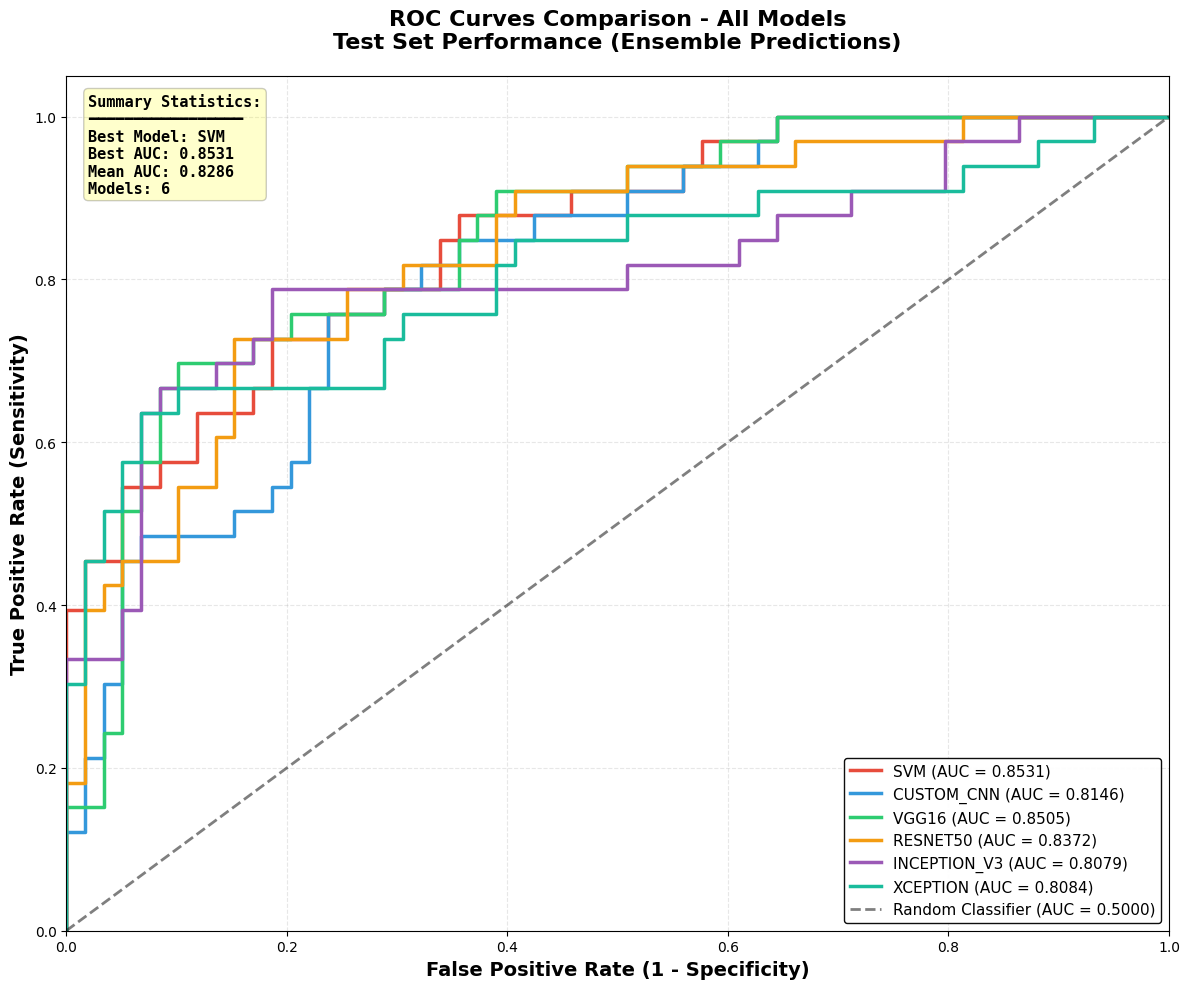

In [ ]:
"""
CELL: Combined ROC Curves Comparison
Purpose: Plot all ROC curves on single figure for comparison
"""

def plot_combined_roc_curves(all_predictions, y_true, save_dir):
    """
    Plot all ROC curves together for comparison
    
    Args:
        all_predictions: Dictionary of all model predictions
        y_true: True labels
        save_dir: Directory to save figure
    """
    
    print("\n" + "="*70)
    print("GENERATING COMBINED ROC CURVES")
    print("="*70 + "\n")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color palette
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
    
    auc_scores = []
    model_names_plotted = []
    
    # Plot each model
    for idx, (model_name, color) in enumerate(zip(all_models, colors)):
        if model_name in all_predictions and 'y_prob_ensemble' in all_predictions[model_name]:
            y_prob = all_predictions[model_name]['y_prob_ensemble']
            
            # Skip if probabilities are invalid
            if len(np.unique(y_prob)) == 1:
                print(f"⚠ Skipping {model_name}: Invalid probabilities")
                continue
            
            # Calculate ROC
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            
            # Plot
            ax.plot(fpr, tpr, color=color, lw=2.5, 
                   label=f'{model_name.upper()} (AUC = {roc_auc:.4f})')
            
            auc_scores.append(roc_auc)
            model_names_plotted.append(model_name.upper())
            
            print(f"✓ {model_name.upper()}: AUC = {roc_auc:.4f}")
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, 
           label='Random Classifier (AUC = 0.5000)')
    
    # Styling
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)', 
                  fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Sensitivity)', 
                  fontsize=14, fontweight='bold')
    
    # Title
    title_text = (
        'ROC Curves Comparison - All Models\n'
        'Test Set Performance'
    )
    ax.set_title(title_text, fontsize=16, fontweight='bold', pad=20)
    
    # Legend
    ax.legend(loc='lower right', fontsize=11, framealpha=0.95, 
             edgecolor='black', fancybox=True)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add summary box
    if auc_scores:
        best_idx = np.argmax(auc_scores)
        best_model = model_names_plotted[best_idx]
        best_auc = auc_scores[best_idx]
        mean_auc = np.mean(auc_scores)
        
        summary_text = (
            f'Summary Statistics:\n'
            f'━━━━━━━━━━━━━━━━━\n'
            f'Best Model: {best_model}\n'
            f'Best AUC: {best_auc:.4f}\n'
            f'Mean AUC: {mean_auc:.4f}\n'
            f'Models: {len(auc_scores)}'
        )
        
        props = dict(boxstyle='round', facecolor='yellow', alpha=0.2)
        ax.text(0.02, 0.98, summary_text, transform=ax.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=props, family='monospace', fontweight='bold')
    
    plt.tight_layout()
    
    # Save
    save_path = save_dir / 'combined_roc_curves_comparison.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✅ Saved combined ROC curves to: {save_path}")
    
    plt.show()
    plt.close()
    
    print("="*70 + "\n")

# Plot combined ROC curves
if all_test_predictions:
    plot_combined_roc_curves(all_test_predictions, y_test, figures_extended_dir)
else:
    print("⚠️  No predictions available for ROC curves")

In [ ]:
"""
CELL: Test Set Performance Comparison
Purpose: Compare all models on test set
"""

def plot_test_performance_comparison(all_predictions, y_test, save_dir):
    """
    Compare model performance on test set
    """
    
    if y_test is None:
        print("⚠ No test labels available")
        return
    
    # Calculate metrics for each model
    metrics_data = []
    
    for model_name, preds in all_predictions.items():
        if 'y_pred_ensemble' not in preds:
            continue
        
        y_pred = preds['y_pred_ensemble']
        y_prob = preds.get('y_prob_ensemble', None)
        
        # Calculate metrics
        accuracy = np.mean(y_pred == y_test)
        
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        if y_prob is not None:
            auc_score = roc_auc_score(y_test, y_prob)
        else:
            auc_score = 0
        
        metrics_data.append({
            'Model': model_name.upper(),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'Specificity': specificity,
            'F1-Score': f1,
            'AUC': auc_score
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Test Set Performance Comparison (All Models)', 
                 fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'AUC']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        values = df_metrics[metric].values
        models = df_metrics['Model'].values
        
        bars = ax.bar(range(len(models)), values, 
                     color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Highlight best
        best_idx = np.argmax(values)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, values)):
            height = bar.get_height()
            label = f'{val:.4f}'
            if i == best_idx:
                label += ' ★'
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   label, ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.set_ylabel(metric, fontsize=11, fontweight='bold')
        ax.set_title(f'{metric}\n(Best: {models[best_idx]})', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    
    # Save
    save_path = save_dir / 'test_performance_comparison.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {save_path.name}")
    
    plt.show()
    plt.close()
    
    # Print summary table
    print("\n" + "="*80)
    print("TEST SET PERFORMANCE SUMMARY")
    print("="*80)
    print(df_metrics.to_string(index=False))
    print("="*80)
    
    return df_metrics

# Generate comparison
test_metrics_df = plot_test_performance_comparison(all_test_predictions, y_test, figures_extended_dir)